In [53]:
#!git clone https://github.com/fany02656/Typicality_project.git

Cloning into 'Typicality_project'...
remote: Enumerating objects: 246, done.
remote: Counting objects: 100% (152/152), done.
remote: Compressing objects: 100% (149/149), done.
remote: Total 246 (delta 3), reused 150 (delta 2), pack-reused 94
Receiving objects: 100% (246/246), 19.76 MiB | 22.71 MiB/s, done.
Resolving deltas: 100% (3/3), done.


Git clone之后把'Car_Plane'文件夹rename为'Vehicle', 'lighthouse'->'Lighthouse', 'church'->'Church'.

typicality_score是按Breden的paper里计算的，image process我们还可以再讨论。

感觉所有的score都偏低，可以其他的model也试一下，可能只是GoogLeNet的问题，也有可能需要重新找一些图替换，也有可能是因为我process的问题。

仅作参考，继续讨论。

In [4]:
import torch
model = torch.hub.load('pytorch/vision:v0.9.0', 'googlenet', pretrained=True)
model.eval()

Using cache found in C:\Users\Yi Wen/.cache\torch\hub\pytorch_vision_v0.9.0


GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [3]:
from PIL import Image
from torchvision import transforms
import os

# Load data: if Mac iOS
path='/content/drive/MyDrive/typicality/Typicality_project/Image'
images={}
directory=['Landscape_Scenery/Mountain', 'Landscape_Scenery/Beach', 
           'Daily_Object/Mug_resized', 'Daily_Object/Banana_resized', 
           'Vehicle/Car', 'Vehicle/Plane', 
           'Architecture/Lighthouse', 'Architecture/Church']

for dir in directory:
  images[dir]=[file for file in os.listdir(path+'/'+dir)]

In [6]:
#Load data: if Windows
# path='Image'

# images={}
# directory=['Landscape_Scenery/Mountain', 'Landscape_Scenery/Beach', 
#            'Daily_Object/Mug_resized', 'Daily_Object/Banana_resized', 
#            'Vehicle/Car', 'Vehicle/Plane', 
#            'Architecture/Lighthouse', 'Architecture/Church']

# for dir in directory:
#     images[dir]=[file for file in os.listdir(path+'/'+dir) if file.endswith(('jpeg', 'jpg'))]

In [7]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [8]:
#type prob cate+filename
all_img={'type':[], 'typicality_score': [], 'dir':[]}

In [9]:
for cate, filename in images.items():
  for f in filename:
    dir=os.path.join(path,cate,f)
    img=Image.open(dir)
    #print(dir)
    input_tensor=preprocess(img)
    input_batch = input_tensor.unsqueeze(0)

    if torch.cuda.is_available():
      input_batch= input_batch.to('cuda')
      model.to('cuda')

    with torch.no_grad():
      output = model(input_batch)

    probabilities = torch.nn.functional.softmax(output[0], dim=0)
    typ_score=round(float(probabilities.max()*100),1)

    all_img['dir'].append(dir)
    all_img['typicality_score'].append(typ_score)
    if 'Mountain' in cate:
      all_img['type'].append('Mountain')
    if 'Beach' in cate:
      all_img['type'].append('Beach')
    if 'Mug' in cate:
      all_img['type'].append('Mug')
    if 'Banana' in cate:
      all_img['type'].append('Banana')
    if 'Car' in cate:
      all_img['type'].append('Car')
    if 'Plane' in cate:
      all_img['type'].append('Plane')
    if 'Lighthouse' in cate:
      all_img['type'].append('Lighthouse')
    if 'Church' in cate:
      all_img['type'].append('Church')

    #print('Typicality of ',f, ' = ',probabilities.max()*100)

In [10]:
import pandas as pd
all_img_df=pd.DataFrame(all_img)
all_img_df.head()
#len(all_img_df)

,type,typicality_score,dir
0,Mountain,66.1,Image\Landscape_Scenery/Mountain\m1.jpg
1,Mountain,82.5,Image\Landscape_Scenery/Mountain\m11.jpg
2,Mountain,20.3,Image\Landscape_Scenery/Mountain\m12.jpg
3,Mountain,38.7,Image\Landscape_Scenery/Mountain\m14.jpg
4,Mountain,70.1,Image\Landscape_Scenery/Mountain\m15.jpg


In [11]:
all_img_df['type'].value_counts()

Lighthouse    19
Church        18
Mug           16
Beach         16
Plane         16
Mountain      16
Car           16
Banana        15
Name: type, dtype: int64

In [12]:
all_img_df['7_score']=round(all_img_df['typicality_score']*7/100,1)
all_img_df.head()

,type,typicality_score,dir,7_score
0,Mountain,66.1,Image\Landscape_Scenery/Mountain\m1.jpg,4.6
1,Mountain,82.5,Image\Landscape_Scenery/Mountain\m11.jpg,5.8
2,Mountain,20.3,Image\Landscape_Scenery/Mountain\m12.jpg,1.4
3,Mountain,38.7,Image\Landscape_Scenery/Mountain\m14.jpg,2.7
4,Mountain,70.1,Image\Landscape_Scenery/Mountain\m15.jpg,4.9


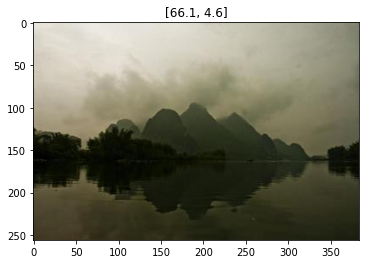

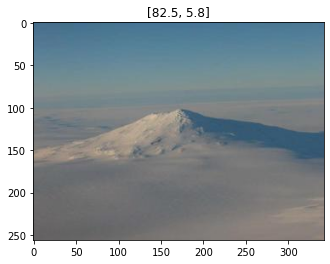

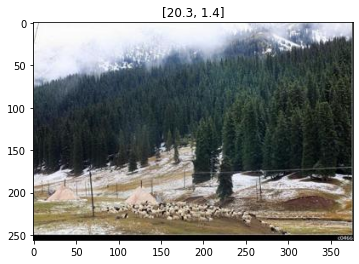

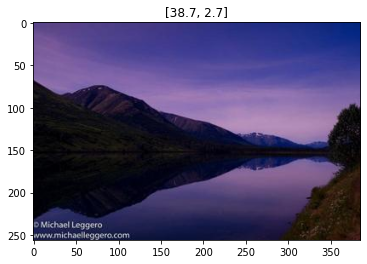

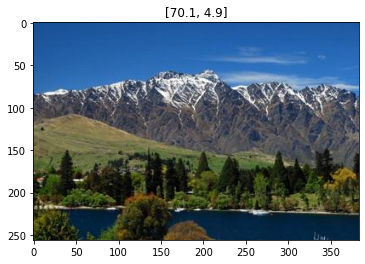

In [13]:
import matplotlib.pyplot as plt
score=[]
for i in range(5):
  dir=all_img_df['dir'][i]
  score.append([all_img_df['typicality_score'][i], all_img_df['7_score'][i]])
  img=Image.open(dir)
  plt.imshow(img)
  plt.title(score[i])
  plt.show()

In [14]:
all_img_df.groupby('type')['typicality_score', '7_score'].describe()

<ipython-input-14-4ca9a3b261a8>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  all_img_df.groupby('type')['typicality_score', '7_score'].describe()


typicality_score                                             \
                      count       mean        std   min     25%    50%   
type                                                                     
Banana                 15.0  70.073333  33.486724   7.7  47.950  78.60   
Beach                  16.0  56.162500  20.008627  16.8  49.250  59.15   
Car                    16.0  44.712500  26.605685   8.4  23.475  36.30   
Church                 18.0  55.722222  18.659946  17.3  43.150  47.90   
Lighthouse             19.0  75.694737  25.389247  11.2  62.800  84.70   
Mountain               16.0  44.875000  21.640163  16.5  27.275  45.70   
Mug                    16.0  47.656250  13.097479  20.3  39.500  48.65   
Plane                  16.0  49.643750  25.878047  10.9  27.500  42.50   

                          7_score                                        \
               75%    max   count      mean       std  min    25%   50%   
type                                                                      
Banana      99.850  100.0    15.0  4.906667  2.355682  0.5  3.350  5.50   
Beach       73.725   80.8    16.0  3.925000  1.399762  1.2  3.425  4.15   
Car         71.025   81.0    16.0  3.143750  1.866536  0.6  1.650  2.55   
Church      69.300   87.1    18.0  3.911111  1.307845  1.2  3.025  3.40   
Lighthouse  93.300   98.8    19.0  5.289474  1.767891  0.8  4.400  5.90   
Mountain    58.750   82.5    16.0  3.137500  1.515201  1.2  1.925  3.20   
Mug         54.725   76.5    16.0  3.343750  0.927339  1.4  2.775  3.45   
Plane       73.425   92.1    16.0  3.468750  1.805812  0.8  1.925  2.95   

                        
              75%  max  
type                    
Banana      7.000  7.0  
Beach       5.125  5.7  
Car         4.950  5.7  
Church      4.900  6.1  
Lighthouse  6.500  6.9  
Mountain    4.075  5.8  
Mug         3.825  5.4  
Plane       5.175  6.4

array([[<AxesSubplot:title={'center':'Banana'}>,
        <AxesSubplot:title={'center':'Beach'}>,
        <AxesSubplot:title={'center':'Car'}>],
       [<AxesSubplot:title={'center':'Church'}>,
        <AxesSubplot:title={'center':'Lighthouse'}>,
        <AxesSubplot:title={'center':'Mountain'}>],
       [<AxesSubplot:title={'center':'Mug'}>,
        <AxesSubplot:title={'center':'Plane'}>, <AxesSubplot:>]],
      dtype=object)

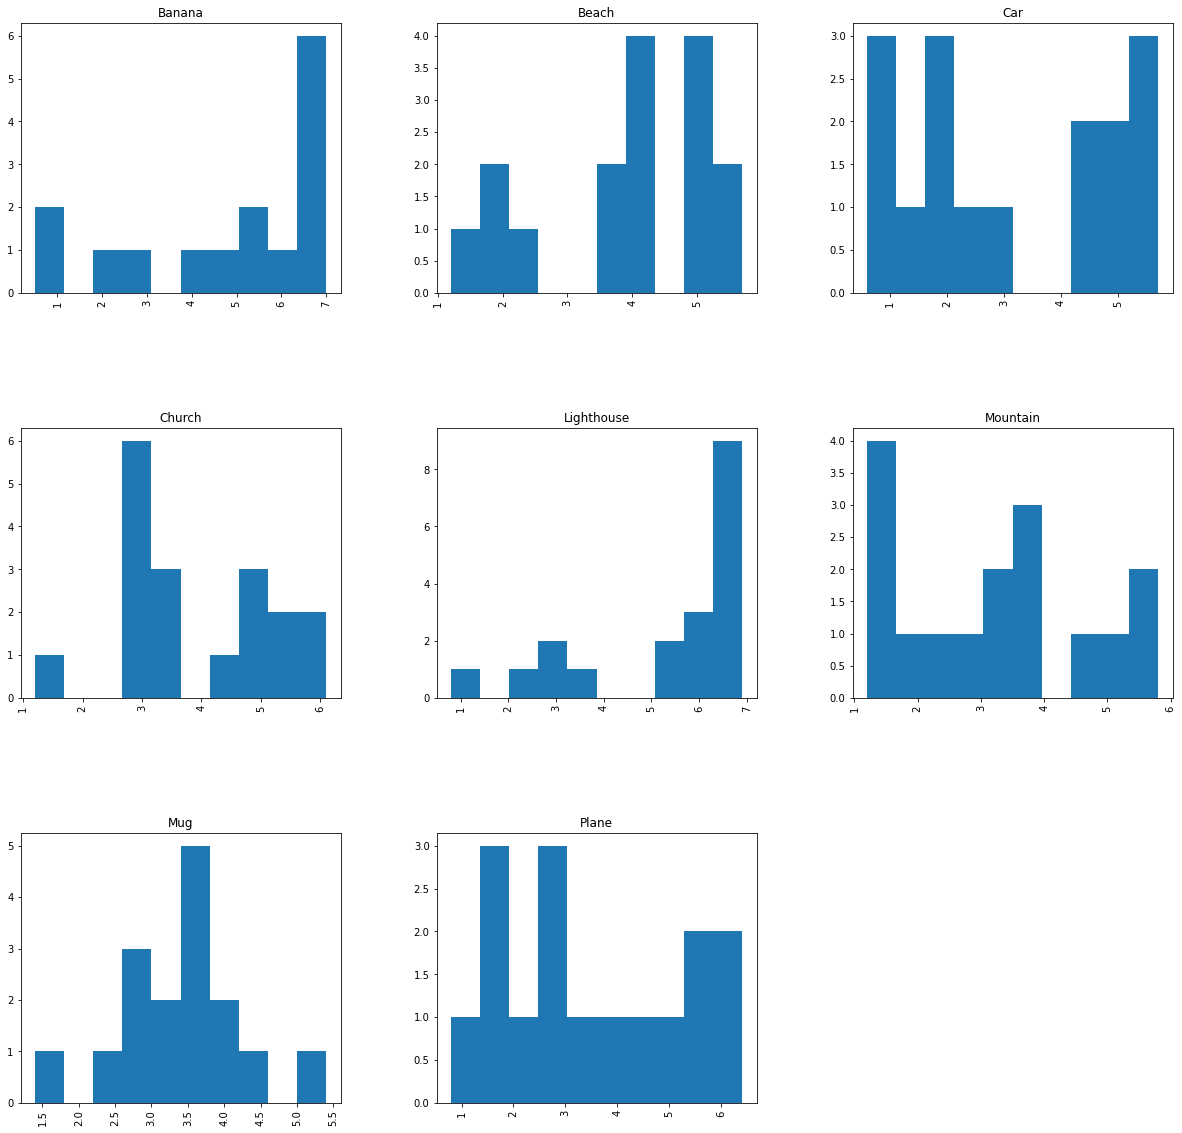

In [15]:
all_img_df['7_score'].hist(by=all_img_df['type'], figsize = (20,20))